# FIR route discrepancy studies

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [71]:

def get_dfs(folder = "202112"):
    """load and return FIR csvs"""

    folder = "Eurocontrol_data/"+ folder + "/"

    # make sure there is only one file of each type in the folder
    filed = []
    actual=[]
    files = os.listdir(folder)
    for file in files:
        if file.startswith("Flight_FIRs_Actual"):
            actual.append(file)
        elif file.startswith("Flight_FIRs_Filed"):
            filed.append(file)
    assert len(filed)==1
    assert len(actual)==1
    filed = filed[0]
    actual= actual[0]

    #r read csvs
    actual_df = pd.read_csv(folder+actual)
    filed_df = pd.read_csv(folder+filed)
    
    return filed_df, actual_df

def get_diffs(folder = "202112"):
    """Calculate how long the flight is in each FIR"""
    filed_df, actual_df = get_dfs(folder)

    # parse dates
    actual_df['Entry Time'] = pd.to_datetime(actual_df['Entry Time'], format='%d-%m-%Y %H:%M:%S')
    actual_df['Exit Time'] = pd.to_datetime(actual_df['Exit Time'], format='%d-%m-%Y %H:%M:%S')
    filed_df['Entry Time'] = pd.to_datetime(filed_df['Entry Time'], format='%d-%m-%Y %H:%M:%S')
    filed_df['Exit Time'] = pd.to_datetime(filed_df['Exit Time'], format='%d-%m-%Y %H:%M:%S')

    # calculate difference, drop absolute times
    actual_df["diff"] = actual_df["Exit Time"] - actual_df["Entry Time"]
    actual_df = actual_df.drop(["Entry Time","Exit Time"], axis=1)
    filed_df["diff"] = filed_df["Exit Time"] - filed_df["Entry Time"]
    filed_df = filed_df.drop(["Entry Time","Exit Time"], axis=1)

    return filed_df, actual_df

def calculate_offroute_duration(folder = None, filed_df = None, actual_df = None, percentile_qs = [25,50,75]):
    """Calculate statistics of duration in FIRs where actuale route differs from filed"""
    if folder:
        filed_df, actual_df = get_diffs(folder)
    
    # do not need sequence number for this
    filed_df = filed_df.drop("Sequence Number", axis=1)
    actual_df = actual_df.drop("Sequence Number", axis=1)

    # sum the duration of one FIR appearing several times
    filed_df = filed_df.groupby(["ECTRL ID", "FIR ID"]).sum()
    actual_df = actual_df.groupby(["ECTRL ID", "FIR ID"]).sum()

    df = pd.merge(filed_df, actual_df, how="outer", left_index=True, right_index=True,suffixes=("_f","_a"))

    df["diff_a"] = df["diff_a"].dt.total_seconds()/60
    df["diff_f"] = df["diff_f"].dt.total_seconds()/60

 
    median_any_f = df["diff_f"].median()
    median_any_a = df["diff_a"].median()
    median_only_f = df[df.isna()["diff_a"]]["diff_f"].median()
    median_only_a = df[df.isna()["diff_f"]]["diff_a"].median()
    
    result = [median_any_f, median_any_a, median_only_f, median_only_a]
    for q in percentile_qs:
        result.append(np.percentile(df["diff_f"].dropna(),q))
        result.append(np.percentile(df["diff_a"].dropna(),q))
        result.append(np.percentile(df[df.isna()["diff_a"]]["diff_f"],q))
        result.append(np.percentile(df[df.isna()["diff_f"]]["diff_a"],q))

    return result

def count_equal_sequences(folder = None, 
                          filed_df = None, 
                          actual_df = None, 
                          ):
    """Counts and returns 
    - how many of the flights have the same FIRs, in the same chronology
    - number of flights in total
    - number of FIRs that are equal at the same position in a flight
    - number of FIRs in all the flights in total
    - memory usage of the df
    """
    if folder:
        filed_df, actual_df = get_diffs(folder)

    filed_df = filed_df.set_index(["ECTRL ID", "Sequence Number"], verify_integrity=True)
    actual_df = actual_df.set_index(["ECTRL ID", "Sequence Number"], verify_integrity=True)
    df = pd.merge(filed_df, actual_df, how="outer", left_index=True, right_index=True,suffixes=("_f","_a"))
    df["same"] = df["FIR ID_a"] == df["FIR ID_f"]
    n_equal_firs = df["same"].sum()
    n_firs = len(df)
    memory_usage = df.memory_usage(deep=True).sum()

    same_route = df.groupby(level="ECTRL ID").all()[["same"]]
    n_equal_routes = same_route["same"].sum()
    n_flights = len(same_route)

    return n_equal_routes, n_flights, n_equal_firs, n_firs, memory_usage

def count_equal_fir_combinations(folder = None, 
                          filed_df = None, 
                          actual_df = None, 
                          ):
    """Counts and returns 
    - how many of the flights have the same set of FIRs, in any chronology
    - number of flights in total
    - number of FIRs that exist in both the filed and actual flight
    - number of FIRs in all the flights in total
    - memory usage of the df
    """
    if folder:
        filed_df, actual_df = get_diffs(folder)

    filed_df = filed_df.groupby(["ECTRL ID", "FIR ID"]).first().reset_index()
    actual_df = actual_df.groupby(["ECTRL ID", "FIR ID"]).first().reset_index()
        
    filed_df = filed_df.set_index(["ECTRL ID", "FIR ID"], verify_integrity=True)
    actual_df = actual_df.set_index(["ECTRL ID", "FIR ID"], verify_integrity=True)

    df = pd.merge(filed_df, actual_df, how="outer", left_index=True, right_index=True,suffixes=("_f","_a"))
    n_firs = len(df)
    n_equal_firs = n_firs - df[["diff_a", "diff_f"]].isna().sum().sum()
    df["same"] = (df["diff_a"] + df["diff_f"]).notna()
    memory_usage = df.memory_usage(deep=True).sum()

    same_route = df.groupby(level="ECTRL ID").all()[["same"]]
    n_equal_routes = same_route["same"].sum()
    n_flights = len(same_route)

    return n_equal_routes, n_flights, n_equal_firs, n_firs, memory_usage



def count_equal_sequences_with_augmentation(folder = None, filed_df = None, actual_df = None):
    """"call count_equal_sequences and count_equal_fir_combinations
    with original dataframes,
    after merging FIRs with UIRs
    and after merging FIRs starting with the same two letters
    (such FIRs are in the same country/area, and may be under the same UIR)"""
    if folder:
        filed_df, actual_df = get_diffs(folder)

    # as is    
    n_equal_routes, n_flights, n_equal_firs, n_firs, memory_usage = count_equal_sequences(filed_df = filed_df, actual_df = actual_df)
    results.extend([n_flights, memory_usage])
    results.extend([n_equal_routes, n_equal_firs, n_firs])
    # ... with repeated firs ignored
    n_equal_routes, n_flights, n_equal_firs, n_firs, memory_usage = count_equal_fir_combinations(filed_df = filed_df, actual_df = actual_df)
    results.extend([n_equal_routes, n_equal_firs, n_firs])

    # remove 5th letter to merge FIR and UIRs
    filed_df["FIR ID"] = filed_df["FIR ID"].map(lambda firid: firid[:4] + firid[-2:])
    actual_df["FIR ID"]=actual_df["FIR ID"].map(lambda firid: firid[:4] + firid[-2:])
    n_equal_routes, n_flights, n_equal_firs, n_firs, memory_usage = count_equal_sequences(filed_df = filed_df, actual_df = actual_df)
    results.extend([n_equal_routes, n_equal_firs, n_firs])
    # ... with repeated firs ignored
    n_equal_routes, n_flights, n_equal_firs, n_firs, memory_usage = count_equal_fir_combinations(filed_df = filed_df, actual_df = actual_df)
    results.extend([n_equal_routes, n_equal_firs, n_firs])


    # remove 3rd and 4th letter as well, to merge adjacent FIRs, (possibly under same UIR)
    filed_df["FIR ID"] = filed_df["FIR ID"].map(lambda firid: firid[:2] + firid[-2:])
    actual_df["FIR ID"]=actual_df["FIR ID"].map(lambda firid: firid[:2] + firid[-2:])
    n_equal_routes, n_flights, n_equal_firs, n_firs, memory_usage = count_equal_sequences(filed_df = filed_df, actual_df = actual_df)
    results.extend([n_equal_routes, n_equal_firs, n_firs])
    # ... with repeated firs ignored
    n_equal_routes, n_flights, n_equal_firs, n_firs, memory_usage = count_equal_fir_combinations(filed_df = filed_df, actual_df = actual_df)
    results.extend([n_equal_routes, n_equal_firs, n_firs])
    return results




## Q: How often are there deviations from the filed route?
We count all flights with a different sequence in FIRs in files and actual.
We also count flights with different sets of FIRs (.i.e. not counting when one FIR is visited several times)


A lot of the discrepancies are deviations in the height dimension:
"In some cases there is a vertical division of the FIR, in which case the lower portion remains named as such, whereas the airspace above is termed an upper information region (UIR)."
(https://en.wikipedia.org/wiki/Flight_information_region)
We ignore the thirs last letter of the FIR ID ("F" or "U") to ignore this distinction.

However, the horisontal divisions UIRs and FIRs are not always straigt above each other.
(compare the FIR and UIR charts in https://www.eurocontrol.int/publication/flight-information-region-firuir-charts-2023)
It seems this mostly (possibly only?) happens within a region using the same first two letters in the FIR.
We therefore ignore the next two ones as well as the F or U.
Note that any FIR starting on the same two letters are in the same country/region.


In [3]:
all_results = []
for folder in os.listdir("Eurocontrol_data"):
    if folder.startswith("20"):
        print("Checking folder", folder)
        try:
            results = count_equal_sequences_with_augmentation(folder)
        except ValueError as m:
            print("failed folder", folder, m)
        print(results)
        all_results.append(results)
    else:
        print("skipping folder", folder)

Checking folder 202109
[652298, 810440321, 505472, 4427374, 5296454, 541255, 4846737, 4989206, 505602, 4453828, 5296454, 568273, 4390658, 4489232, 509255, 4533063, 5296454, 615577, 3837962, 3878065]
Checking folder 201509
[860990, 995909281, 660726, 5528766, 6398040, 673211, 6031042, 6304000, 660956, 5564546, 6398040, 699158, 5503107, 5717784, 662921, 5623169, 6398040, 726841, 4954402, 5104167]
Checking folder 202012
failed folder 202012 Index has duplicate keys: MultiIndex([(242438551, 10),
            (242438551, 11),
            (242438612, 19),
            (242438642, 18),
            (242438645, 17),
            (242438645, 18),
            (242438666,  4),
            (242438666,  5),
            (242438666,  6),
            (242438666,  7),
            ...
            (242445447,  2),
            (242445447,  3),
            (242445447,  4),
            (242445447,  5),
            (242445447,  6),
            (242445449,  2),
            (242445449,  3),
            (242445449,

In [4]:
all_results = pd.DataFrame(data=all_results, columns = ["n_flights", "memory_usage",
                                                        *[string+f"_{suffix}" for suffix in ["", "fir", "merge1", "merg1_fir", "merge2", "merge2_fir"] for string in ["n_equal_routes", "n_equal_firs", "n_firs"]]
                                                        ])
all_results

,n_flights,memory_usage,n_equal_routes_,n_equal_firs_,n_firs_,n_equal_routes_fir,n_equal_firs_fir,n_firs_fir,n_equal_routes_merge1,n_equal_firs_merge1,n_firs_merge1,n_equal_routes_merg1_fir,n_equal_firs_merg1_fir,n_firs_merg1_fir,n_equal_routes_merge2,n_equal_firs_merge2,n_firs_merge2,n_equal_routes_merge2_fir,n_equal_firs_merge2_fir,n_firs_merge2_fir
0,652298,810440321,505472,4427374,5296454,541255,4846737,4989206,505602,4453828,5296454,568273,4390658,4489232,509255,4533063,5296454,615577,3837962,3878065
1,860990,995909281,660726,5528766,6398040,673211,6031042,6304000,660956,5564546,6398040,699158,5503107,5717784,662921,5623169,6398040,726841,4954402,5104167
2,860990,995909281,660726,5528766,6398040,673211,6031042,6304000,660956,5564546,6398040,699158,5503107,5717784,662921,5623169,6398040,726841,4954402,5104167
3,892252,1044473214,679802,5786082,6723263,693449,6329118,6616132,680003,5826305,6723263,721263,5763773,5988434,682027,5889138,6723263,750391,5168054,5327508
4,777241,891341435,596213,5037779,5815542,608044,5464759,5708527,596390,5069734,5815542,630873,5015664,5212387,598949,5127390,5815542,658857,4466057,4597196
5,963973,1193076449,745365,6517932,7735562,795358,7058644,7273913,745819,6566380,7735562,844813,6420119,6559955,752682,6667042,7735562,912894,5711622,5767761
6,864221,1015555428,652746,5580086,6533366,665864,6136619,6425892,652941,5620218,6533366,693020,5589440,5816951,654939,5684478,6533366,721791,5010208,5173010
7,447215,552922596,345008,2942166,3579677,368473,3268743,3371711,345111,2959670,3579677,385677,2972157,3046742,347833,3016961,3579677,417351,2579397,2612797
8,851297,983613703,653462,5460000,6315586,665712,5958638,6229392,653690,5495507,6315586,691077,5434667,5647246,655792,5553041,6315586,719778,4889476,5037176
9,696285,793887119,533442,4458419,5168001,543654,4865537,5085146,533593,4488085,5168001,565655,4452294,4624580,535270,4538126,5168001,588567,3974524,4094719


In [5]:
all_results.sum()

n_flights                       20286935
memory_usage                 24038635784
n_equal_routes_                 15645082
n_equal_firs_                  133096640
n_firs_                        155860921
n_equal_routes_fir              16291688
n_equal_firs_fir               144784448
n_firs_fir                     150303726
n_equal_routes_merge1           15650597
n_equal_firs_merge1            133963998
n_firs_merge1                  155860921
n_equal_routes_merg1_fir        17047221
n_equal_firs_merg1_fir         132210300
n_firs_merg1_fir               136329111
n_equal_routes_merge2           15740875
n_equal_firs_merge2            135753856
n_firs_merge2                  155860921
n_equal_routes_merge2_fir       18065195
n_equal_firs_merge2_fir        117703284
n_firs_merge2_fir              120177066
dtype: int64

In [ ]:
all_results.loc["sum"] = all_results.sum()


In [24]:
all_results.loc["sum"][["n_equal_routes_", "n_equal_routes_merge1", "n_equal_routes_merge2","n_equal_routes_fir","n_equal_routes_merg1_fir","n_equal_routes_merge2_fir"]] / all_results.loc["sum","n_flights"]

n_equal_routes_              0.771190
n_equal_routes_merge1        0.771462
n_equal_routes_merge2        0.775912
n_equal_routes_fir           0.803063
n_equal_routes_merg1_fir     0.840305
n_equal_routes_merge2_fir    0.890484
Name: sum, dtype: float64

In [58]:
print("Ram required to store all dfs:", all_results.loc["sum","memory_usage"]/1024**3, "GB")

Ram required to store all dfs: 22.387724168598652 GB


We conclude that 23% of flights do not follow the filed route exaclty, while only 11% have a different set of merged FIRs.

## Duration of discrepancies
A small spacial deviation from the planned route can cause the plane to enter a FIR not included in the filed route. (if the planned path just misses it)
But in this case, the plane will not stay in the FIR for a long time (it will only cut a corner).
Similarly, the flight can be planned to just enter a FIR, but the plane misses it.

If most discrepancies are such small deviations, the durations in these FIRs will be short.
Lets test this

In [94]:

def calculate_offroute_duration_with_augmentation(folder = None, filed_df = None, actual_df = None, qs=[25,50,75]):


    if folder:
        filed_df, actual_df = get_diffs(folder)
    durations = pd.DataFrame(columns = ["median", 
                                        *[f"q{q}" for q in qs] ])

    # as is    
    res = calculate_offroute_duration(filed_df = filed_df, actual_df = actual_df, percentile_qs=qs)
    combined_res = (np.array(res)[::2]+np.array(res)[1::2])/2
    durations.loc["origial, all"] = combined_res[::2]
    durations.loc["origial, discrepant"] = combined_res[1::2]

    # remove 5th letter to merge FIR and UIRs
    filed_df["FIR ID"] = filed_df["FIR ID"].map(lambda firid: firid[:4] + firid[-2:])
    actual_df["FIR ID"]=actual_df["FIR ID"].map(lambda firid: firid[:4] + firid[-2:])
    res = calculate_offroute_duration(filed_df = filed_df, actual_df = actual_df, percentile_qs=qs)
    combined_res = (np.array(res)[::2]+np.array(res)[1::2])/2
    durations.loc["FIR+UIR, all"] = combined_res[::2]
    durations.loc["FIR+UIR, discrepant"] = combined_res[1::2]


    # remove 3rd and 4th letter as well, to merge adjacent FIRs, (possibly under same UIR)
    filed_df["FIR ID"] = filed_df["FIR ID"].map(lambda firid: firid[:2] + firid[-2:])
    actual_df["FIR ID"]=actual_df["FIR ID"].map(lambda firid: firid[:2] + firid[-2:])
    res = calculate_offroute_duration(filed_df = filed_df, actual_df = actual_df, percentile_qs=qs)
    combined_res = (np.array(res)[::2]+np.array(res)[1::2])/2
    durations.loc["merge_FIRS, all"] = combined_res[::2]
    durations.loc["merge_FIRS, discrepant"] = combined_res[1::2]

    return durations

In [95]:
calculate_offroute_duration_with_augmentation("202103", qs=[5,10,25,50,75,90,95])


,median,q5,q10,q25,q50,q75,q90,q95
"origial, all",15.050000,4.333333,6.858333,10.000000,15.050000,30.658333,55.716667,74.725000
"origial, discrepant",2.050000,0.216667,0.400000,0.891667,2.050000,4.650000,12.025000,20.212500
"FIR+UIR, all",17.408333,5.000000,7.950000,10.000000,17.408333,34.608333,59.758333,77.000000
"FIR+UIR, discrepant",2.025000,0.216667,0.416667,0.906250,2.025000,4.445833,10.550000,17.538750
"merge_FIRS, all",18.033333,5.050000,9.241667,10.000000,18.033333,40.483333,70.408333,96.624583
"merge_FIRS, discrepant",2.175000,0.200000,0.325000,0.950000,2.175000,5.175000,11.645833,19.808333


In [96]:
calculate_offroute_duration_with_augmentation("201609", qs=[5,10,25,50,75,90,95])



,median,q5,q10,q25,q50,q75,q90,q95
"origial, all",13.958333,3.683333,5.933333,10.000000,13.958333,25.000000,45.408333,65.000000
"origial, discrepant",1.850000,0.258333,0.450000,0.941667,1.850000,3.731250,7.791667,13.174583
"FIR+UIR, all",15.358333,4.341667,6.925000,10.000000,15.358333,29.950000,50.200000,68.825000
"FIR+UIR, discrepant",1.558333,0.216667,0.358333,0.766667,1.558333,3.408333,7.241667,11.850000
"merge_FIRS, all",16.200000,5.000000,8.000000,10.000000,16.200000,34.866667,59.825000,82.400000
"merge_FIRS, discrepant",1.050000,0.166667,0.283333,0.591667,1.050000,2.158333,6.066667,10.813333


In both of these files, the time in discrepant FIRs are mostly very short.
Lets plot to see better:


## PLotting durations

In [110]:
def plot_offroute_duration(folder = None, filed_df = None, actual_df = None, ax = plt):
    """Plot histogram of duration in FIRs where actuale route differs from filed"""
    if folder:
        filed_df, actual_df = get_diffs(folder)
    
    # do not need sequence number for this
    filed_df = filed_df.drop("Sequence Number", axis=1)
    actual_df = actual_df.drop("Sequence Number", axis=1)

    # sum the duration of one FIR appearing several times
    filed_df = filed_df.groupby(["ECTRL ID", "FIR ID"]).sum()
    actual_df = actual_df.groupby(["ECTRL ID", "FIR ID"]).sum()

    df = pd.merge(filed_df, actual_df, how="outer", left_index=True, right_index=True,suffixes=("_f","_a"))

    # get time differece in minutes
    df["diff_a"] = df["diff_a"].dt.total_seconds()/60
    df["diff_f"] = df["diff_f"].dt.total_seconds()/60

 
    all = np.concatenate((df["diff_f"].values, df["diff_a"].values))
    disc =np.concatenate((df[df.isna()["diff_a"]]["diff_f"].values, df[df.isna()["diff_f"]]["diff_a"].values))

    # repeat these values, to scale the height of the histogram more similar to the one with all the FIRs.
    disc = np.tile(disc, len(all)//len(disc))

    ax.hist(all, bins=1000)
    ax.hist(disc, bins=1000, alpha=0.6)
    
    

In [116]:

def plot_offroute_duration_with_augmentation(folder = None, filed_df = None, actual_df = None):
    if folder:
        filed_df, actual_df = get_diffs(folder)

    fig, axs = plt.subplots(3,1,sharex=True, figsize=(15,8))

    # as is    
    res = calculate_offroute_duration(filed_df = filed_df, actual_df = actual_df, ax=axs[0])


    # remove 5th letter to merge FIR and UIRs
    filed_df["FIR ID"] = filed_df["FIR ID"].map(lambda firid: firid[:4] + firid[-2:])
    actual_df["FIR ID"]=actual_df["FIR ID"].map(lambda firid: firid[:4] + firid[-2:])
    res = calculate_offroute_duration(filed_df = filed_df, actual_df = actual_df, ax=axs[1])


    # remove 3rd and 4th letter as well, to merge adjacent FIRs, (possibly under same UIR)
    filed_df["FIR ID"] = filed_df["FIR ID"].map(lambda firid: firid[:2] + firid[-2:])
    actual_df["FIR ID"]=actual_df["FIR ID"].map(lambda firid: firid[:2] + firid[-2:])
    res = calculate_offroute_duration(filed_df = filed_df, actual_df = actual_df, ax=axs[2])

    axs[1].set_xlim(-1, 80)

    plt.show()



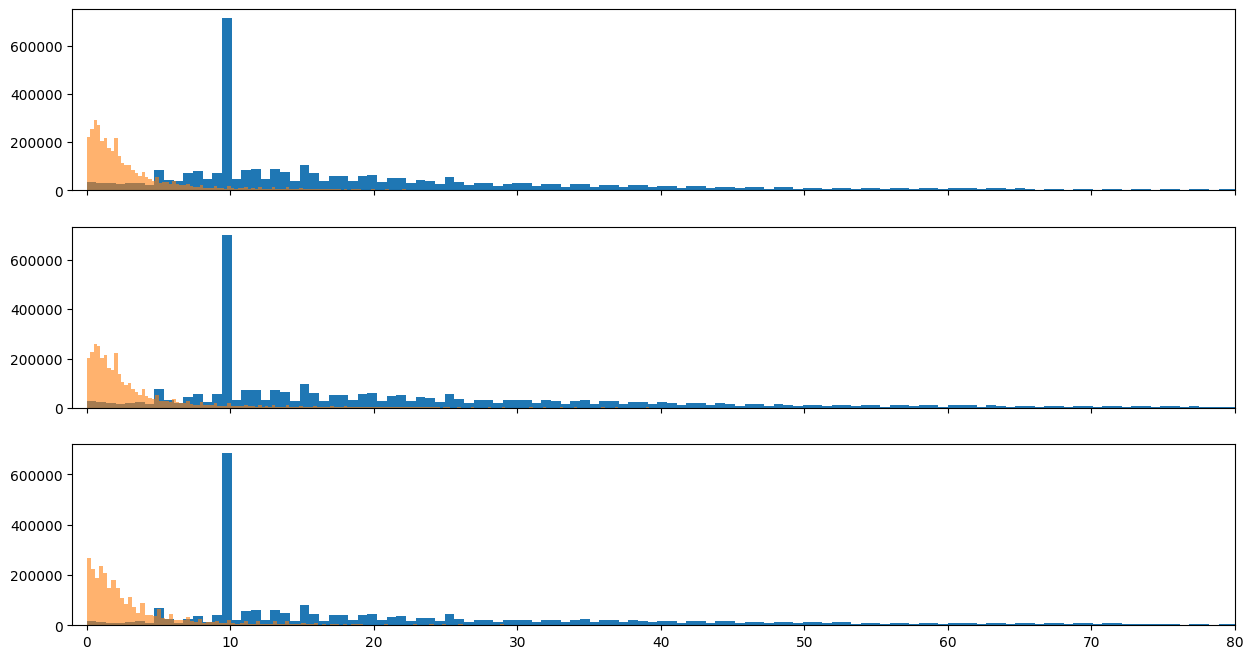

In [117]:
plot_offroute_duration_with_augmentation("202103")


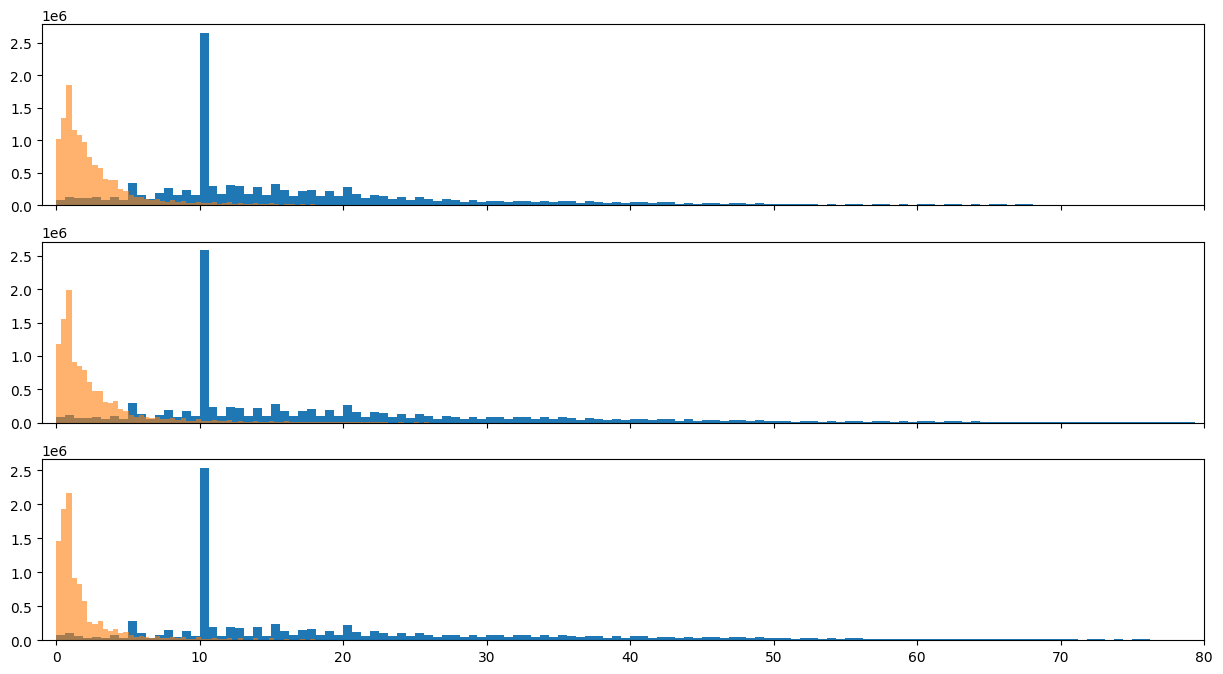

In [118]:
plot_offroute_duration_with_augmentation("201609")


Why is there so many instances at 10 minutes?